In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv('HF_TOKEN')

from src import SemanticRecommender
from src.evaluation import evaluate_retriever

df = pd.read_pickle("../data/processed/en_movies_processed.pkl")
test_set = df.sample(2000, random_state=42)

In [2]:
model_variants = [
    "all-MiniLM-L6-v2",           # 384 dim
    "all-mpnet-base-v2",          # 768 dim
    "paraphrase-MiniLM-L3-v2",    # 384 dim
    "google/embeddinggemma-300m"  # 768 dim
]

In [3]:

results = []

for i, model_name in enumerate(model_variants, 1):
    print(f"Evaluating: {model_name}")
    retriever = SemanticRecommender(df, model_name=model_name, token=hf_token)
    start_time = time.time()
    retriever.encode_all()
    encoding_time = time.time() - start_time
    
    scores = evaluate_retriever(retriever, test_set, k_values=[5, 10])
    
    result = {
        "model_name": model_name,
        "variant_name": retriever.get_variant_name(),
        "encoding_time_s": encoding_time,
        **scores
    }
    results.append(result)

Evaluating: all-MiniLM-L6-v2


Batches:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating: all-mpnet-base-v2


Batches:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating: paraphrase-MiniLM-L3-v2


Batches:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating: google/embeddinggemma-300m


Batches:   0%|          | 0/141 [00:00<?, ?it/s]

In [4]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('precision@5', ascending=False)

print(df_results[['model_name', 'precision@5', 'jaccard@5', 'content_div@5', 'query_time_ms', 'encoding_time_s']].to_string(index=False))

df_results.to_csv('../data/results/semantic_eval.csv', index=False)

                model_name  precision@5  jaccard@5  content_div@5  query_time_ms  encoding_time_s
google/embeddinggemma-300m       0.8127   0.397303       0.715280       2.706368       254.853926
         all-mpnet-base-v2       0.7790   0.370599       0.689937       2.576563        73.140973
          all-MiniLM-L6-v2       0.7363   0.339992       0.652698       2.622762        18.206315
   paraphrase-MiniLM-L3-v2       0.7177   0.323761       0.708230       2.643060         9.768453


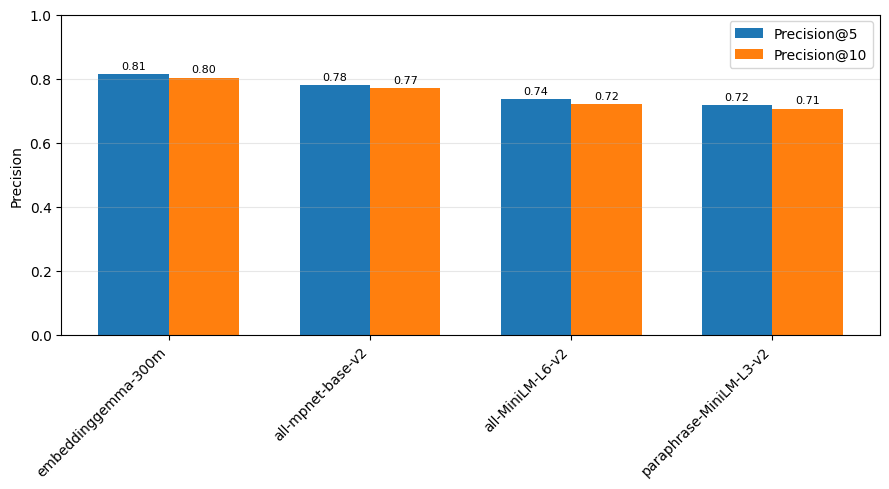

In [25]:
fig, ax = plt.subplots(figsize=(9, 5))

models = [m.split('/')[-1] for m in df_results['model_name']]
x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, df_results['precision@5'], width, label='Precision@5')
bars2 = ax.bar(x + width/2, df_results['precision@10'], width, label='Precision@10')

ax.set_ylabel('Precision')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}',
            ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}',
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../data/results/semantic_precision.png', dpi=150, bbox_inches='tight')
plt.show()

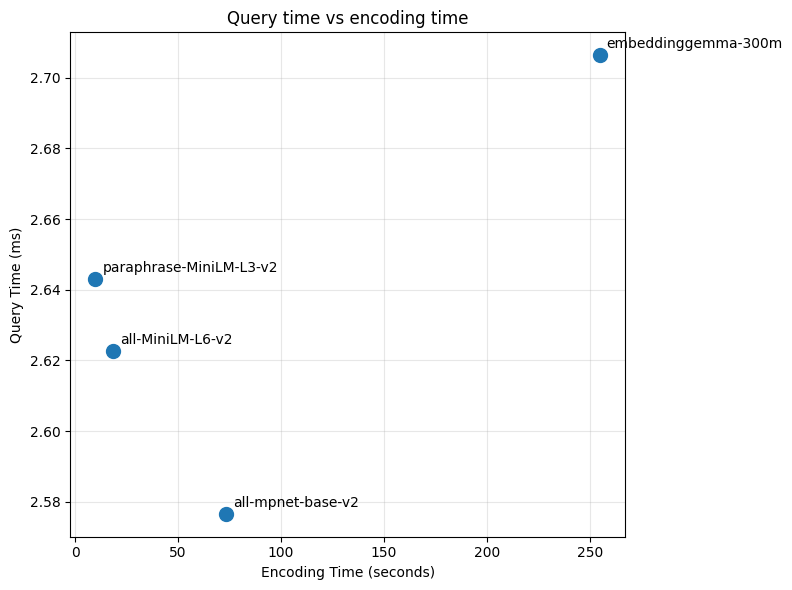

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df_results['encoding_time_s'], df_results['query_time_ms'], s=100)

for _, row in df_results.iterrows():
    ax.annotate(row['model_name'].split('/')[-1],
                (row['encoding_time_s'], row['query_time_ms']),
                xytext=(5, 5), textcoords='offset points')

ax.set_xlabel('Encoding Time (seconds)')
ax.set_ylabel('Query Time (ms)')
ax.set_title('Query time vs encoding time')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/results/semantic_time_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

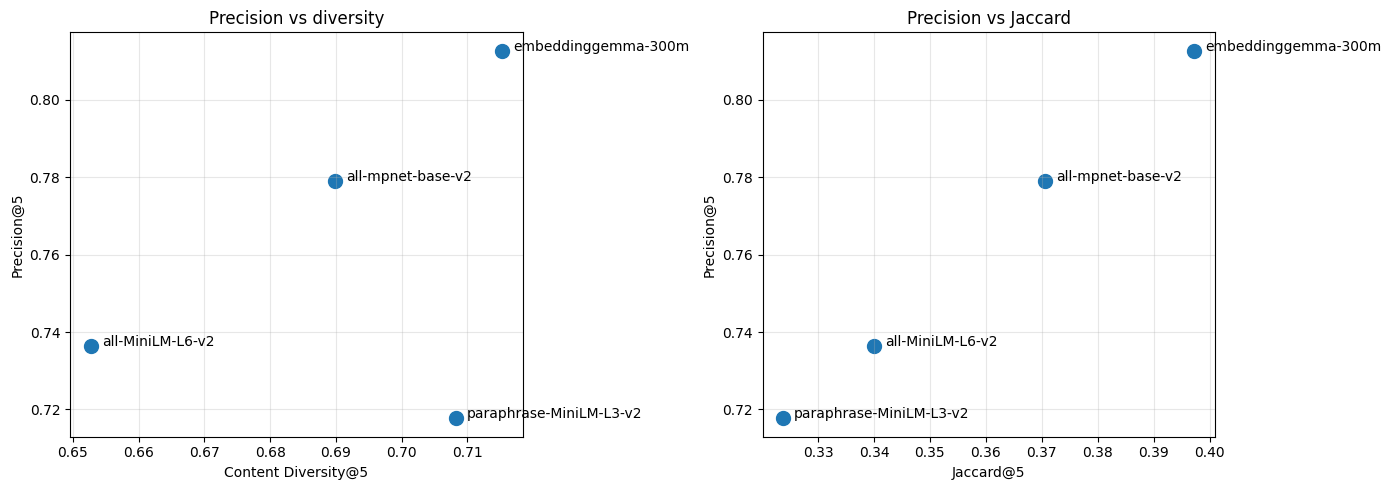

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.scatter(df_results['content_div@5'], df_results['precision@5'], s=100)
for _, row in df_results.iterrows():
    ax.annotate(row['model_name'].split('/')[-1],
                (row['content_div@5'], row['precision@5']),
                xytext=(8, 0), textcoords='offset points')
ax.set_xlabel('Content Diversity@5')
ax.set_ylabel('Precision@5')
ax.set_title('Precision vs diversity')
ax.grid(alpha=0.3)

ax = axes[1]
ax.scatter(df_results['jaccard@5'], df_results['precision@5'], s=100)
for _, row in df_results.iterrows():
    ax.annotate(row['model_name'].split('/')[-1],
                (row['jaccard@5'], row['precision@5']),
                xytext=(8, 0), textcoords='offset points')
ax.set_xlabel('Jaccard@5')
ax.set_ylabel('Precision@5')
ax.set_title('Precision vs Jaccard')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/results/semantic_analysis.png', dpi=150, bbox_inches='tight')
plt.show()